Create a Logistic Regression model
---

#### Criteria

> Can we detect the most common words people use to tweet about traffic incidents?

Reflecting on our problem statement, we are focusing on the interpretability of our model rather than predicatbility. However, our model should still be somewhat reliable to use in production. The following is our criteria to help choose a trustworthy model:

&#9744; Performs better than the baseline model

&#9744; Not overfit

&#9744; Interpretable coefficient weights

---


Import libraries
---

In [1]:
import GetOldTweets3 as got
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from langdetect import detect
import regex as re
import pickle
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

Import I-10 data
---

In [2]:
df = pd.read_csv('../data/combined_incident_data.csv')

df.head()

,tweet,username,after_incident
0,Terrebonne: Gray: The LA 660 Coteau Rd Bridge ...,Houma_Traffic,1
1,"Western State East Standings: 1. Citrus 22-6, ...",sgnlthelgthoops,1
2,South Coast North Standings: 1. East Los Angel...,sgnlthelgthoops,1
3,All lanes are open I-10 East at mile marker 12...,Laf_Traffic,1
4,The exit ramp I-10 East at mile marker 121 (Bu...,Laf_Traffic,1


Pre-modeling
---

**Assign $X$ and $y$ variables**

In [3]:
X = df['tweet']
y = df['after_incident']

**Train-test-split**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 42,
                                                   stratify = y)

**Create a pipeline to model using Logistic Regression**

In [5]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

**Create parameters to Grid Search**

Using a custom stopwords list that's created through countless iterations of the modeling process. Refer to the appendix for the complete list of custom stopwords.

In [6]:
custom_stopwords = pickle.load(open( "../assets/custom_stopwords.pkl", "rb" ))
len(custom_stopwords)

738

In [7]:
params = {
    'cvec__stop_words' : [custom_stopwords],
    'cvec__max_features' : [500],
    'cvec__max_df' : [.8],
    'cvec__min_df' : [.005],
    'cvec__ngram_range' : [(1,3)],
    'logreg__penalty' : ['l1'],
    'logreg__solver' : ['liblinear']}

**Instantiate and fit Grid Search**

In [8]:
gs = GridSearchCV(pipe, params, cv=5)

gs.fit(X_train, y_train);

Model evaluation
---

#### Model Description

The model only takes in the `tweet` column as input and was trained using a few hyperparameters. The most notable at helping us interpret were,
- Custom Stopwords: 700+ words
- N-Gram Range: 1 - 3 word range
- Penalty: Lasso

Compared to other iterations, this model yielded lower accuracy scores overall. But, it fits our criteria of a reliable model for production:

&#9745; Performs better than the baseline model

&#9745; Not overfit

&#9745; Interpretable coefficient weights

---

#### Baseline score

The baseline score is the probability of making a correct prediction at random. In this case, we have a 56% probability of making a correct prediction at random. Additionally, the final model is performing 15 points better than the baseline.

In [9]:
baseline = round(df['after_incident'].value_counts(normalize=True)*100)[0]

print(f' Our baseline score is {baseline}%.')

 Our baseline score is 56.0%.


#### Train and test accuracy scores

The model scored 71% in both training and testing data accuracy, which means it is perfectly fitted and predicts unseen data just as good as trained data.

In [10]:
print(f'Train Score: {round(gs.score(X_train, y_train),2)*100}%')
print(f'Test Score: {round(gs.score(X_test, y_test),2)*100}%')

Train Score: 71.0%
Test Score: 71.0%


#### Coefficient weights

Most importantly, the top 10 - 50 coefficient weights give valuable, interpretable, insights to the most common words people use to tweet about traffic incidents. Hence, we are utilizing this model for production.

The coefficient weights gives us an idea of the most contributive features, in this case, words (or word combinations), in our model. The stronger the coefficient weight, the more contributive the feature is at predicting if a tweet came after an incident happened or not.

For example, all else held constant, if the mention of 'cleared emergency' in a tweet increases by 1 unit, we expect a 37 increase in odds ratio of the tweet posted after an incident happened.

We are able to draw descriptive, interpretable coefficient weights when looking at the top 50 coefficient weights. However, for the sake of simplicity in visualization, we are only displaying 10 strongest coefficient weights. As seen on the bar chart below, we still see some noise (e.g. 'shop' and 'pico'), but the majority (80%) of our top coefficient weights are relevant to road statuses.

**Create a data frame to display features and their coefficient weights**

In [11]:
feature_names = gs.best_estimator_.named_steps['cvec'].get_feature_names()

coefficients = gs.best_estimator_.named_steps['logreg'].coef_[0]

coef_df = pd.DataFrame({'features': feature_names, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients]
             })

coef_df.sort_values('exp_coef', ascending=False).head(50)

,features,coef,exp_coef
62,cleared emergency,3.618280,37.273387
80,construction blocked,2.596582,13.417792
186,sigalert,1.481134,4.397931
91,disabled,1.339626,3.817615
183,shop,0.608589,1.837837
131,maintenance,0.605413,1.832008
66,close,0.595939,1.814735
191,stalled car,0.540835,1.717440
160,pico,0.536976,1.710826
68,closure,0.487025,1.627467


**Plot top 10 exponentiated coefficient weights**

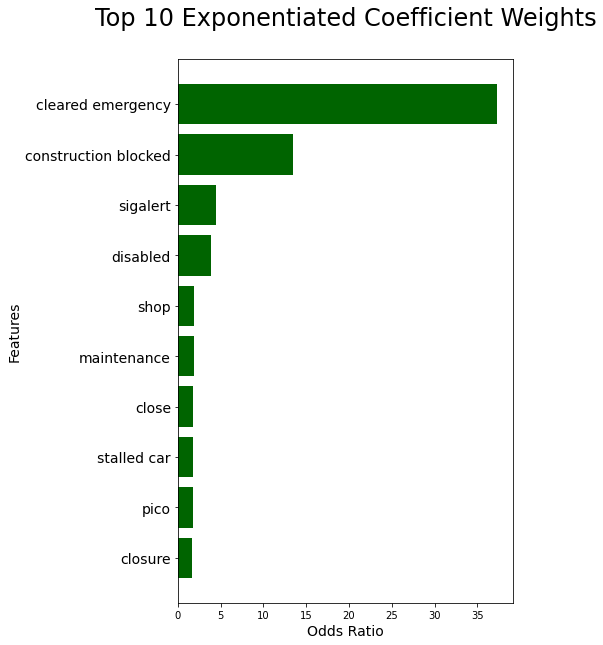

In [12]:
top10 = coef_df.sort_values('exp_coef', ascending=False).drop(columns='coef').head(10)

plot10 = top10.sort_values('exp_coef', ascending=True)

plt.figure(figsize=(6,10))
plt.barh(plot10['features'].values,
         plot10['exp_coef'].values,
         color='darkgreen')

plt.title('Top 10 Exponentiated Coefficient Weights\n', fontsize=24)
plt.xlabel('Odds Ratio', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.yticks(fontsize=14);

plt.savefig('../assets/plot10.png', dpi=235, bbox_inches='tight')

Next steps
---

As a proof of concept, we are using relevant coefficient weights as incident keywords to predict if a tweet was about an incident on the routes suggested by Google Maps during the Saddleridge Fire. Below are a list of the most relevant features from the top 50 coefficient weights:
```
['cleared emergency',
 'construction blocked',
 'sigalert',
 'disabled',
 'maintenance',
 'close',
 'stalled car',
 'closure',
 'stop',
 'crash blocking',
 'restriction',
 'police activity',
 'closed',
 'disabled vehicle',
 'collision unkn',
 'collision unkn incident',
 'new planned construction',
 'congestion 345',
 'congestion 345 28',
 'construction',
 'cleared planned construction',
 'cleared planned',
 'construction blocked 05',
 'construction ramp',
 'expect delays',
 'emergency construction blocked',
 'emergency',
 'injuries']
```

---
APPENDIX
---

Below is the code to a buildable a custom stopwords list.

In [13]:
stopwords_to_add = [
    'flower',
    'amore',
    'dolce',
    'downey',
    'wedding',
    'events',
    '726',
    '2222',
    '1004',
    '132',
    '90640',
    'picoftheday',
    'whittier',
    'california',
    '2019',
    'road',
    'update',
    'run',
    'year',
    'day',
    '76',
    'eo',
    'st',
    'bestoftheday',
    'flowers',
    'way',
    'high',
    'driving',
    'open',
    'abc',
    'morning',
    'think',
    '23',
    'near',
    'work',
    'california',
    'picorivera',
    'news',
    'fox11',
    'abc',
    '203',
    'duval',
    'graffiti',
    'rt',
    'ly',
    '17hvnju',
    'inj',
    'utm_source',
    'ig_twitter_share',
    'inj',
    'phxtraffic',
    'mins',
    '1141',
    'enrt',
    'wilshire',
    '90403',
    'various',
    'line',
    '174',
    '12',
    'wanna',
    'fun',
    'ofr',
    'dr',
    'i405',
    '405',
    'entrance',
    'got',
    '90',
    'latraffic',
    '12',
    'aspx',
    'id',
    'culvercity',
    'loop',
    'westla',
    'lp',
    'com',
    'tickets',
    'instagood',
    'tomorrow',
    'cute',
    'walk',
    'person',
    'long',
    'venice',
    'avenue',
    '71',
    'right',
    'old',
    'hills',
    'gadsden',
    'mm',
    'exposition',
    'lns',
    'come',
    'game',
    'monday',
    '25',
    '67th',
    'av',
    'lunch',
    'best',
    'comedy',
    'stage',
    'jackson',
    '71',
    'right',
    'ago',
    'malibu',
    'house',
    '00',
    'saw',
    'gang',
    'feb',
    'final',
    'montebello',
    'plan',
    'milepost',
    'shooting',
    'beverly',
    'constellation',
    'blvd',
    'boulevard',
    'ca-2',
    'ca2',
    'sr2',
    'sr-2',
    'state',
    'route',
    '2',
    'santa',
    'monica',
    'sm',
    'avenue',
    'stars',
    'ave',
    'of',
    'the',
    'venice',
    'right',
    'hills',
    'exposition',
    'lns',
    'come',
    'game',
    'monday',
    '25',
    '67th',
    'av',
    'lunch',
    'best',
    'comedy',
    'stage',
    'jackson',
    'ago',
    'malibu',
    'house',
    '00',
    'saw',
    'gang',
    'feb',
    'final',
    'montebello',
    'plan',
    'milepost',
    'join',
    '01',
    'san',
    'lane',
    'will',
    'love',
    'last',
    'updated',
    'my',
    'blvd',
    'years',
    'ave',
    'to',
    'santa',
    'http',
    'due',
    'fl511',
    'los',
    'santa',
    'monica',
    'boulevard',
    'us',
    'on',
    'santa',
    'south',
    'bit',
    'he',
    'in',
    'west',
    'hollywood',
    'has',
    'el',
    'monte',
    'wb',
    'lincoln',
    'blvd',
    'santa',
    'ca',
    'in',
    'el',
    'monte',
    'updated',
    'losangeles',
    'freeway',
    'i605',
    'boulevard',
    'https',
    'east',
    'la',
    'pm',
    'lane',
    'is',
    'of',
    'the',
    'stars',
    'west',
    'park',
    'city',
    '24',
    '10',
    'igshid',
    'beach',
    'i10',
    '161',
    'left',
    'gov',
    'street',
    '17',
    'www',
    'instagram',
    'bernardino',
    'i10',
    '45',
    'sunset',
    '90404',
    '90401',
    'lafsp',
    'i10',
    'angeles',
    '04',
    '40',
    'want',
    '15',
    'sm',
    'bus',
    'wow',
    'motorcycle',
    'usa',
    'minimal',
    'details',
    'century',
    '90405',
    'dallas',
    'amazing',
    'weho',
    'texas',
    'la',
    'i10',
    'sunday',
    'sunland',
    'rider',
    '605',
    'reached',
    'chp',
    'home',
    '21',
    'glendale',
    '343',
    'river',
    'coast',
    '11',
    'santamonica',
    'tonight',
    '30',
    'lanes',
    '10',
    'amp',
    'nb',
    'baldwin',
    'la',
    'est',
    'clear',
    'hour',
    'exit',
    '343',
    '142',
    'sr',
    '90405',
    'eventdetails',
    'district',
    '323',
    'est',
    'moderate',
    'phoenix',
    '10',
    'bar',
    'pier',
    'mobile',
    'westwood']

In [14]:
cvec_stopwords = list(CountVectorizer(stop_words = 'english').get_stop_words())

nltk_stopwords = stopwords.words('english')

custom_stopwords = list(set(stopwords_to_add)) + cvec_stopwords + nltk_stopwords

In [16]:
pickle.dump(custom_stopwords, open("custom_stopwords.pkl", "wb"))